In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pickle
import src.EP_model as EP_model
import src.utils as utils

%load_ext autoreload
%autoreload 2
#%matplotlib ipympl
%matplotlib inline
np.random.seed(100)

folder_name = './results/104_2025-05-05T23:06_MNIST_1000_step_test'
epoch_idx = 88
ep_model = EP_model.EP_model()
ep_model = utils.load_obj(f'{folder_name}/ep_model.pkl')
ep_model.create_schedule()
ep_model.load_trained_param(f'{folder_name}/512', best_epoch=epoch_idx)
x_train, y_train, y_train_idx, x_val, y_val, y_val_idx = utils.load_data('./data/MNIST_1000')

In [2]:
print(y_val_idx[10])
print((x_val[10]+1)*50)

6
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 100 100   0   0   0   0   0]
 [  0   0   0   0   0   0 100 100 100   0   0   0   0   0]
 [  0   0   0   0   0 100 100 100   0   0   0   0   0   0]
 [  0   0   0   0   0 100 100 100   0   0   0   0   0   0]
 [  0   0   0   0   0 100 100   0   0   0   0   0   0   0]
 [  0   0   0   0 100 100 100 100 100 100   0   0   0   0]
 [  0   0   0   0 100 100 100 100 100 100   0   0   0   0]
 [  0   0   0   0 100 100 100 100   0 100 100   0   0   0]
 [  0   0   0   0   0 100 100   0 100 100   0   0   0   0]
 [  0   0   0   0   0 100 100 100 100 100   0   0   0   0]
 [  0   0   0   0   0   0 100 100   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


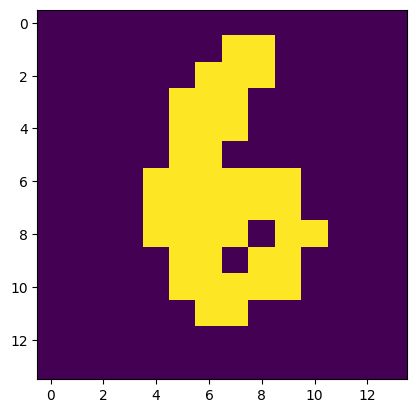

In [3]:
plt.imshow(x_val[10])

In [4]:
temps = np.flip(np.linspace(64, 0, 256, endpoint=False))
N_sample = 2**17
results = []
for i in range(0, 100, 99):
    ep_model.load_trained_param(f'{folder_name}/512', best_epoch=i)
    H = ep_model.H.copy()
    H[ep_model.ising_hidden_idx] += x_val[10].flatten() @ ep_model.W # clamp input
    results.append(utils.analysis(ep_model.J, H, temps, N_sample, burn=1/2))
utils.save_obj(f'{folder_name}/512/thermal_analysis.pkl', results)


100%|██████████| 256/256 [07:45<00:00,  1.82s/it]


In [7]:
#set save to true if want to save model data
save = True

In [6]:
#run this cell if want to load data\
'''
name = '20240424-203931-16x16v1'
location = f'./results_old/{name}/model.pkl'
with open(location, 'rb') as file:
    model = pickle.load(file)
time_used = 'N/A'
'''

"\nname = '20240424-203931-16x16v1'\nlocation = f'./results_old/{name}/model.pkl'\nwith open(location, 'rb') as file:\n    model = pickle.load(file)\ntime_used = 'N/A'\n"

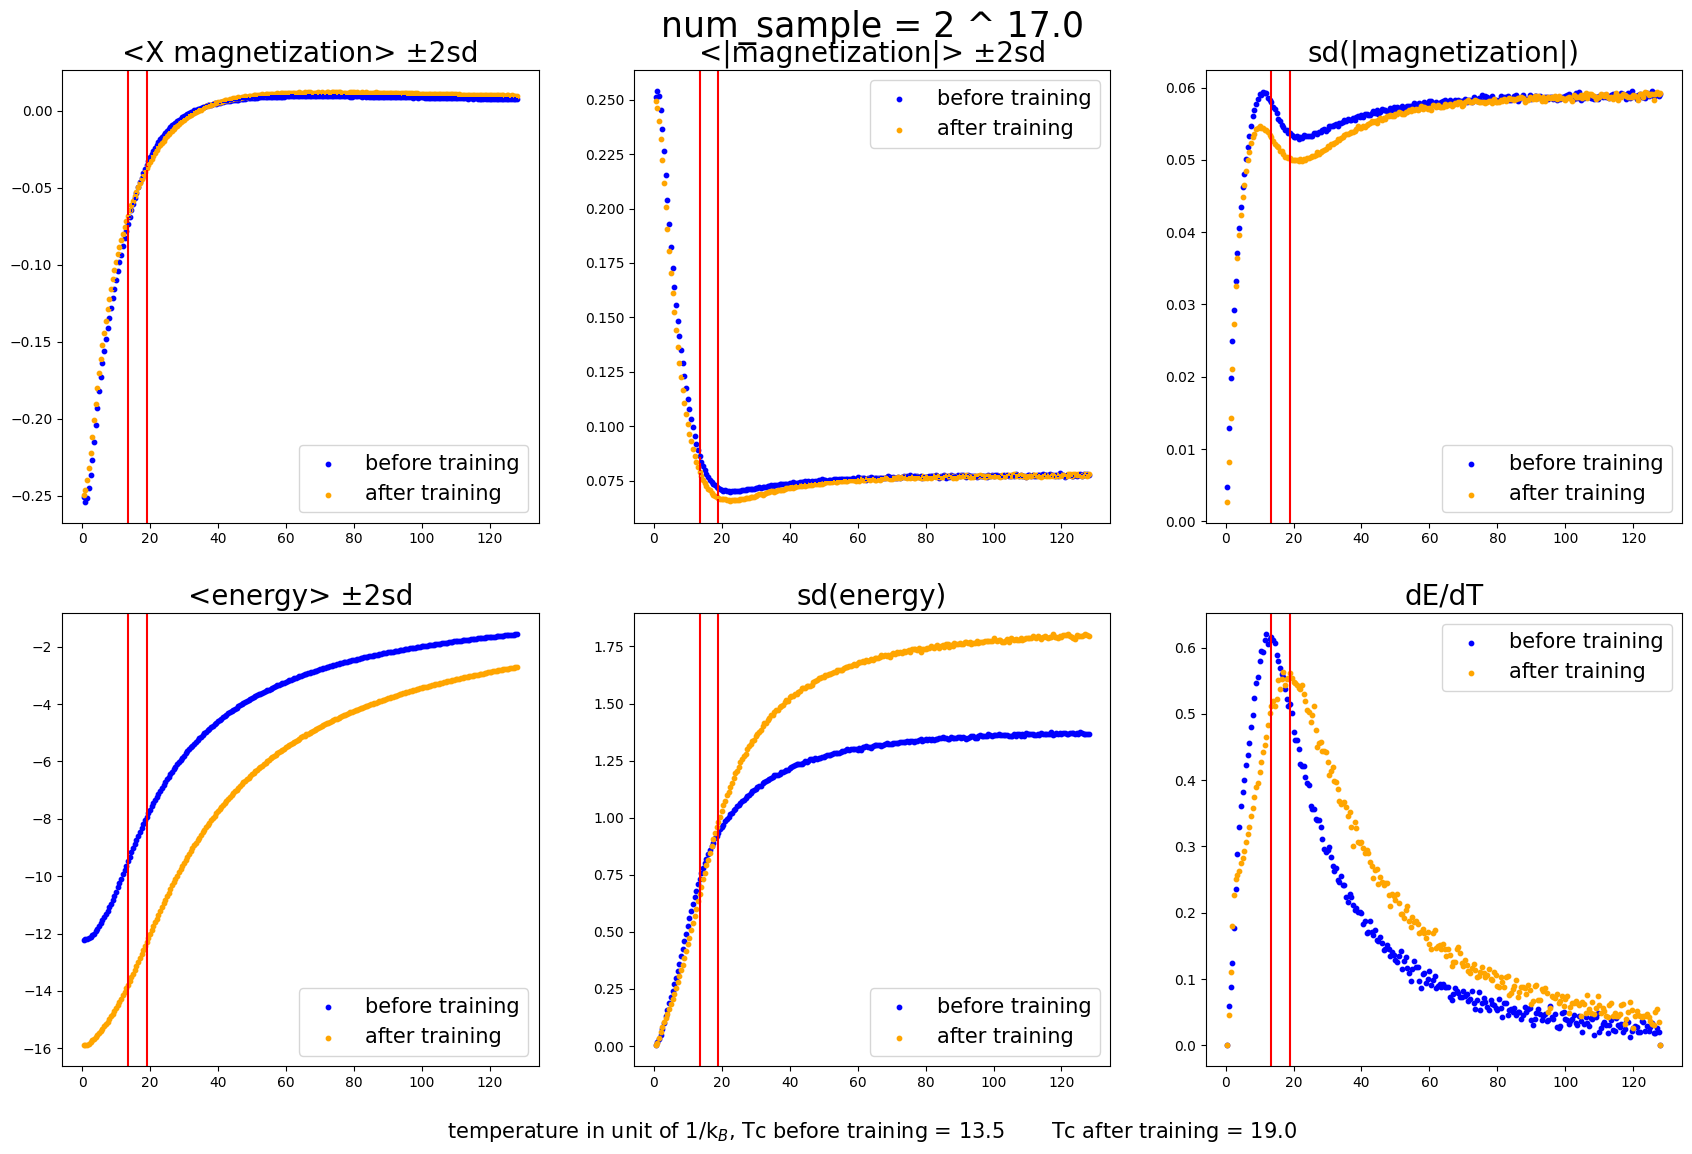

In [8]:
layout = [[0,1, 5],
          [2,3, 4]]
fig, ax = plt.subplot_mosaic(layout, figsize=(18,12))
label = ['<X magnetization> ±2sd', '<|magnetization|> ±2sd', '<energy> ±2sd', 'sd(energy)', 'dE/dT', 'sd(|magnetization|)']
color = ['blue', 'orange']
curve_label = ['before training', 'after training']
for j in [0, 1]:
    result = results[j]
    #note: sd here refer to parameter sd instead of monte carlo sd
    Esd = np.sqrt( np.abs(result['E2'] - (result['E'])**2) )#this error is assuming each config have no correlation with next one
    Esd_scale = 10**np.ceil(np.log10(np.max(Esd)))
    absMsd = np.sqrt( np.abs(result['M2'] - (result['abs_M'])**2 ) )
    Mxsd = np.sqrt( np.abs(result['M2'] - (result['M'])**2 ) )

    scatter = [result['M'], result['abs_M'], result['E'], Esd, utils.calculus_d1(result['E'], temps), absMsd]
    error = [2*Mxsd / np.sqrt(N_sample), 2*absMsd / np.sqrt(N_sample), 2*Esd / np.sqrt(N_sample), None, None, None]
    dot_size = [10, 10, 10, 10, 10, 10]
    y_ticks = [*([np.linspace(-1,1,21)]*1), np.linspace(0,1,21), np.linspace(-2,0,21), np.linspace(0, Esd_scale, 11)]
    num_plot = len(scatter)
    #fig, ax = plt.subplots(1,num_plot,figsize=(8*num_plot,8))

    for i in range(num_plot):
        #ax[i].set_ylabel(label[i], fontsize=15)
        ax[i].set_title(label[i], fontsize=20)
        ax[i].scatter(temps, scatter[i], s=dot_size[i], color=color[j], label=curve_label[j])
        ax[i].axvline(x=result['Tc'], color='red', linestyle='-')
        if error[i] is not None:
            ax[i].errorbar(temps, scatter[i], yerr = 2 * error[i], fmt='none', color=color[j])
        ax[i].legend(fontsize=15)
        #ax[i].set_yticks(y_ticks[i])
plt.subplots_adjust(top=0.93,bottom=0.10, left=0.05, right=0.95)
Tcb4 = results[0]['Tc']
Tcaf = results[1]['Tc']
fig.text(0.5, 0.04, f'temperature in unit of 1/k$_B$, Tc before training = {Tcb4}\tTc after training = {Tcaf}', ha='center', fontsize=15)
fig.suptitle(f'num_sample = 2 ^ {np.log2(N_sample)}\n', fontsize=25)


#change save to True then run this cell if want to save data
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")
if save:
    os.system(f'mkdir -p {folder_name}')
    plt.savefig(f'./{folder_name}/thermal_analysis.png')
    save = False

plt.show()